### Standard Imports

In [1]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), "..", "."))  # add parent dir to path

import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, sampler
from torchvision import datasets, models
from torchvision import transforms as T  # for simplifying the transforms
import timm

# Custom imports
from config import *
from data import *

# Use STIX font for math plotting
plt.rcParams["font.family"] = "STIXGeneral"

import torchvision
from torchvision import transforms
from termcolor import colored
import warnings

warnings.filterwarnings("ignore")

cfg = get_imagenette_config()
print(colored(f"Config:", "green"))
print(cfg)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(colored(f"Using device:", "green"), device)

# Seed for reproducability
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(cfg.seed)
np.random.seed(np.array(cfg.seed))

Config:
batch_size: 8
data_root: /home/zonularity/aecc/data
lr: 0.001
lr_gamma: 0.1
lr_step_size: 15
model_dir: /home/zonularity/aecc/weights
model_name: dae_imagenette.pth
noise_factor: 0.2
num_epochs: 30
num_workers: 4
pin_memory: true
seed: 42
weight_decay: 0.0001

Using device: cuda:0


### Data Loading and Visualization

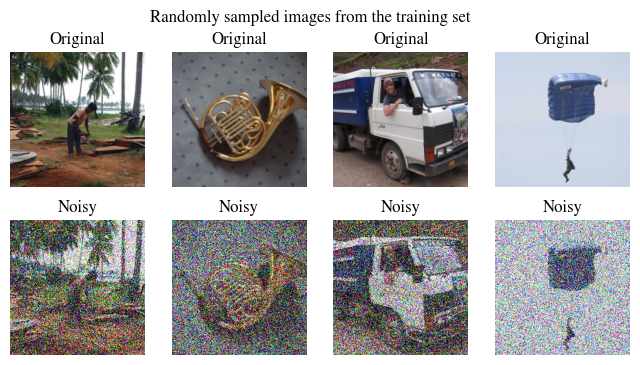

In [2]:
vis_loader, _ = get_dataloader(
    cfg.data_root,
    "train",
    cfg.batch_size,
    cfg.num_workers,
    noise_factor=0.5,
)

# Visualize 4 images; both original and noisy
fig, ax = plt.subplots(2, 4, figsize=(8, 4))
fig.suptitle("Randomly sampled images from the training set")

for i, (img, noisy_img) in enumerate(vis_loader):
    if i == 4:
        break
    ax[0, i].imshow(img[0].permute(1, 2, 0), cmap="gray")
    ax[0, i].set_title("Original")
    ax[0, i].axis("off")
    ax[1, i].imshow(noisy_img[0].permute(1, 2, 0), cmap="gray")
    ax[1, i].set_title("Noisy")
    ax[1, i].axis("off")
plt.show()

### Autoencoder

In [3]:
"""
The idea is to model the transmission of images [of shape 224x224x3] through a noisy 
(wireless channel using an autoencoder. The encoder is trained to compress the image 
into a latent vector, which is then transmitted through the channel. The decoder is 
trained to reconstruct the image from the latent vector. The encoder and decoder are 
trained jointly to minimize the reconstruction loss.

The encoder uses a ResNet50 model, which is a convolutional neural network. The decoder 
uses transposed convolutions to upsample the latent vector into an image. The encoder 
and decoder are trained jointly to minimize the reconstruction loss.
"""

# Parameters
img_size = (224, 224)  # size of the image
num_channels = 3  # number of channels in the image
latent_dim = 2048

import torch
import torch.nn as nn
import torchvision


class DenoisingAutoencoder(nn.Module):
    def __init__(self, num_channels=3, latent_dim=2048):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder (pretrained ResNet50)
        self.encoder = nn.Sequential(
            *list(torchvision.models.resnet50(pretrained=True).children())[:-2]
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                latent_dim, 512, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                512, 256, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                256, 128, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(
                64, num_channels, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
# Test the denoising autoencoder
x = torch.randn(1, num_channels, *img_size)
x = x.to(device)

dae = DenoisingAutoencoder().to(device)

out = dae(x)
print("Output shape:", out.shape)

Output shape: torch.Size([1, 3, 224, 224])


### Training

In [5]:
train_loader, val_loader = get_dataloader(
    cfg.data_root, "train", cfg.batch_size, cfg.num_workers, noise_factor=cfg.noise_factor
)
test_loader = get_dataloader(
    cfg.data_root,
    "test",
    cfg.batch_size,
    cfg.num_workers,
    shuffle=False,
    noise_factor=cfg.noise_factor,
)

print(colored(f"Train loader batches:", "green"), len(train_loader))
print(colored(f"Test loader batches:", "green"), len(test_loader))

Train loader batches: 911
Test loader batches: 474


In [6]:
os.path.exists(os.path.join(cfg.model_dir, cfg.model_name))

True

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr=cfg.lr)
learning_rate_scheduler = optim.lr_scheduler.StepLR(
    optimizer, step_size=cfg.lr_step_size, gamma=cfg.lr_gamma
)

# Training loop
train_loss = []
val_loss = []

if not os.path.exists(os.path.join(cfg.model_dir, cfg.model_name)):
    for epoch in range(cfg.num_epochs):
        # Train
        dae.train()
        train_epoch_loss = 0.0
        with tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{cfg.num_epochs}", unit="batch"
        ) as train_bar:
            for i, (imgs, noisy_imgs) in enumerate(train_bar):
                # noisy_imgs = imgs + cfg.noise_factor * torch.randn(*imgs.shape)
                # noisy_imgs = torch.clamp(noisy_imgs, 0.0, 1.0)
                imgs = imgs.to(device)
                noisy_imgs = noisy_imgs.to(device)

                optimizer.zero_grad()
                out = dae(noisy_imgs)
                loss = criterion(out, imgs)
                loss.backward()
                optimizer.step()

                train_epoch_loss += loss.item()
                train_bar.set_postfix(train_loss=train_epoch_loss / (i + 1))

        train_loss.append(train_epoch_loss / len(train_loader))

        # Validation
        dae.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for imgs, noisy_imgs in val_loader:
                # noisy_imgs = imgs + cfg.noise_factor * torch.randn(*imgs.shape)
                # noisy_imgs = torch.clamp(noisy_imgs, 0.0, 1.0)
                imgs = imgs.to(device)
                noisy_imgs = noisy_imgs.to(device)

                out = dae(noisy_imgs)
                loss = criterion(out, imgs)
                val_epoch_loss += loss.item()

        val_loss.append(val_epoch_loss / len(val_loader))

        learning_rate_scheduler.step()

        # Log results
        print(
            colored("Epoch", "green")
            + f" {epoch+1}/{cfg.num_epochs} | "
            + colored("Train loss:", "yellow")
            + f" {train_epoch_loss/len(train_loader):.5f} | "
            + colored("Validation loss:", "red")
            + f" {val_epoch_loss/len(val_loader):.5f}"
        )

    # Visualize the training and validation loss
    plt.figure(figsize=(6, 4))
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

else:
    print(colored("Skipping training, model already exists!", "red"))

Skipping training, model already exists!


### Save Weights

In [8]:
# Save the model
if not os.path.exists(os.path.join(cfg.model_dir, cfg.model_name)):
    torch.save(dae.state_dict(), os.path.join(cfg.model_dir, cfg.model_name))
    print(colored(f"Model saved to {cfg.model_dir}", "green"))

### Visualize Denoising

In [9]:
dae = DenoisingAutoencoder()
dae.load_state_dict(torch.load(os.path.join(cfg.model_dir, cfg.model_name)))

<All keys matched successfully>

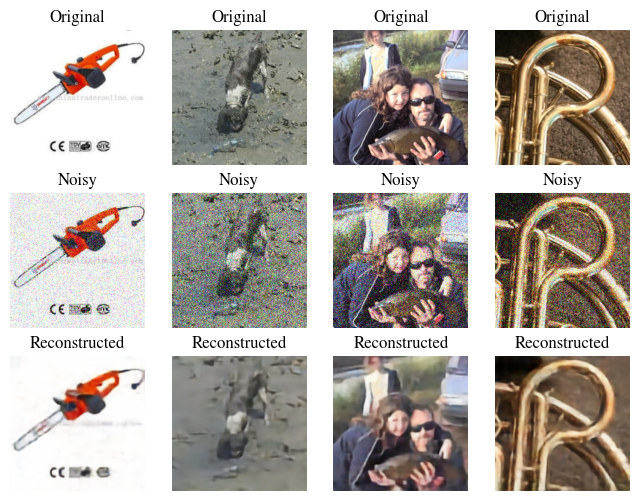

In [10]:
# Visualize the output of the autoencoder
imgs, _ = next(iter(test_loader))
noisy_imgs = imgs + cfg.noise_factor * torch.randn(*imgs.shape)
out = dae(noisy_imgs).detach().cpu()

fig, ax = plt.subplots(3, 4, figsize=(8, 6))

for i in range(4):
    ax[0, i].imshow(torch.clamp(imgs[i], 0, 1).permute(1, 2, 0))
    ax[0, i].set_title("Original")
    ax[0, i].axis("off")
    ax[1, i].imshow(torch.clamp(noisy_imgs[i], 0, 1).permute(1, 2, 0))
    ax[1, i].set_title("Noisy")
    ax[1, i].axis("off")
    ax[2, i].imshow(torch.clamp(out[i], 0, 1).permute(1, 2, 0))
    ax[2, i].set_title("Reconstructed")
    ax[2, i].axis("off")